### NOTE
  * 0과 1 사이로 scaling
  

In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd, metric
from mxnet.gluon import nn, utils
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib as mpl
import os, sys, tarfile, time, logging

In [2]:
batch_size = 64
latent_dim = 200

ctx = mx.gpu()

data_path = 'mnist'

In [3]:
# Fixing the random seed
#mx.random.seed(42)
mnist = mx.test_utils.get_mnist()


### 28 * 28 image iterator
#t = np.array([(x-0.5)*2 for x in mnist['train_data']])
train_data = mx.io.NDArrayIter(mnist['train_data'].reshape((-1, 784)), mnist['train_label'], batch_size, shuffle=True, last_batch_handle = 'discard')

### Print 28 * 28 image

/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1431: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1434: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)


(28, 28)
(28, 28)
(28, 28)


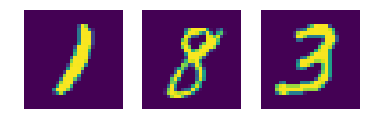

In [4]:
def  visualize(img_arr):
    plt.imshow(img_arr)
    plt.axis('off')

for i, j in enumerate(np.random.choice(range(100), 3)):
    plt.subplot(1,3,i+1)
    print(mnist['train_data'][j + 10][0].shape)
    visualize(mnist['train_data'][j + 10][0])
plt.show()

In [5]:
# build the generator
nc = 3
ngf = 32
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*2) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. () x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('sigmoid'))
    # state size. (nc) x 64 x 64

In [6]:
#class Gen_conv(gluon.HybridBlock):
#    def __init__(self, **kwargs):
#        super(Gen_conv, self).__init__(**kwargs)
#        with self.name_scope():
#            self.dense = nn.Dense(4*4*1024)
#            self.convT1 = nn.Conv2DTranspose(512, kernel_size = 5, strides = 1, use_bias = False)
#            self.convT2 = nn.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
#            self.convT3 = nn.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
#            self.convT4 = nn.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            
#            self.bn1 = nn.BatchNorm()
#            self.bn2 = nn.BatchNorm()
#            self.bn3 = nn.BatchNorm()
#            self.bn4 = nn.BatchNorm()            
            
#    def hybrid_forward(self, F, x):
#        #print('input.shape = {}'.format(x.shape))
#        x = self.dense(x)
#        x = nd.reshape(x, (-1, 1024, 4, 4))
#        #print('x0.shape = {}'.format(x.shape))
#        x = self.convT1(x)
#        x = self.bn1(x)
#        x = nd.relu(x)
#        #print('x1.shape = {}'.format(x.shape))
#        x = self.convT2(x)
#        x = self.bn2(x)
#        x = nd.relu(x)
#        #print('x2.shape = {}'.format(x.shape))
#        x = self.convT3(x)
#        x = self.bn3(x)
#        x = nd.relu(x)
#        #print('x3.shape = {}'.format(x.shape))
#        x = self.convT4(x)
#        x = self.bn4(x)
#        #print('x4.shape = {}'.format(x.shape))
#        return x

In [7]:
X_dim = 784
class Gen_mlp(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Gen_mlp, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = nn.Dense(128, in_units = latent_dim)
            self.dense2 = nn.Dense(X_dim)
            
    def hybrid_forward(self, F, x):
        #print('input.shape = {}'.format(x.shape))
        x = self.dense1(x)
        x = nd.relu(x)
        x = self.dense2(x)
        x = nd.sigmoid(x)
        return x

In [8]:
z = nd.random.uniform(low = -1, high = 1, shape = (64, latent_dim), ctx = ctx)
gen = Gen_mlp()
gen.collect_params().initialize(mx.init.Xavier(), ctx = ctx)
#gen(z)

In [9]:
class Critic(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Critic, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = nn.Dense(64)
            self.dense2 = nn.Dense(1)
            
    def hybrid_forward(self, F, x):
        x = self.dense1(x)
        x = nd.relu(x)
        x = self.dense2(x)
        return x

In [10]:
def get_penalty(critic, real_data, fake_data, _lambda):
    from mxnet import autograd
    alpha = nd.random.uniform(shape = (batch_size,1))
    alpha = nd.repeat(alpha, repeats = real_data.shape[1], axis = 1)
    alpha = alpha.as_in_context(mx.gpu())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.attach_grad()
    with autograd.record():
        z = critic(interpolates)
    z.backward()

    gradients = interpolates.grad

    gradient_penalty = nd.mean(nd.array([(x.norm()**2 - 1).asscalar() for x in gradients])) * _lambda
    
    return gradient_penalty

### Generate data to build penalty

In [11]:
_real_data = mnist['train_data'][:batch_size]
real_data = np.array([x.reshape(-1, 784) for x  in _real_data])
real_data = np.squeeze(real_data, axis = 1)
real_data = nd.array(real_data).as_in_context(mx.gpu())

real_data.shape

fake_data = nd.random.uniform(shape = (batch_size, 784), ctx = mx.gpu())

In [12]:
critic = Critic()
critic.collect_params().initialize(mx.init.Xavier(), ctx =  mx.gpu())

In [13]:
def get_penalty(critic, real_data, fake_data, _lambda):
    from mxnet import autograd
    alpha = nd.random.uniform(shape = (batch_size,1))
    alpha = nd.repeat(alpha, repeats = real_data.shape[1], axis = 1)
    alpha = alpha.as_in_context(mx.gpu())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.attach_grad()
    with autograd.record():
        z = critic(interpolates)
    z.backward()

    gradients = interpolates.grad
    gradient_penalty = nd.mean(nd.array([(x.norm()**2 - 1).asscalar() for x in gradients], ctx = ctx)) * _lambda
    
    return gradient_penalty

## Train

In [14]:
epochs = 100
log_freq = 5

disc_study_rate = 1
n_critic_steps = 5
clip = .01
iter_loss = dict()
iter_loss['crit'] = []
iter_loss['gen'] = []

ctx = mx.gpu() 

lr = .00002
beta1 = 0.5

In [15]:
gen = Gen_mlp()
critic = Critic()
gen.collect_params().initialize(mx.init.Normal(0.02), ctx = mx.gpu())
critic.collect_params().initialize(mx.init.Normal(0.02), ctx = mx.gpu())

In [16]:
gen_trainer = gluon.Trainer(gen.collect_params(), 'RMSProp', {'learning_rate': lr})
critic_trainer = gluon.Trainer(critic.collect_params(), 'RMSProp', {'learning_rate': lr})

speed: 94.38160848617554 seconds
distance = -15.085907 at epoch 0


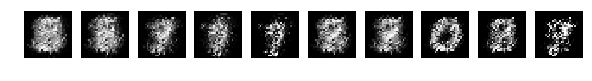

speed: 94.55001616477966 seconds
distance = 8.156731 at epoch 5


<Figure size 432x288 with 0 Axes>

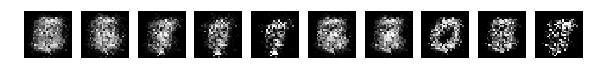

speed: 94.87021327018738 seconds
distance = 44.840378 at epoch 10


<Figure size 432x288 with 0 Axes>

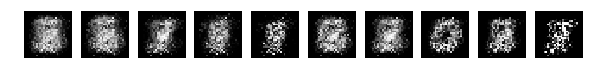

speed: 95.2635989189148 seconds
distance = -51.083305 at epoch 15


<Figure size 432x288 with 0 Axes>

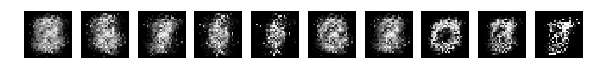

speed: 94.35912203788757 seconds
distance = 5.268684 at epoch 20


<Figure size 432x288 with 0 Axes>

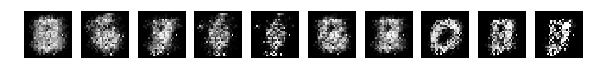

speed: 94.12788105010986 seconds
distance = 19.434738 at epoch 25


<Figure size 432x288 with 0 Axes>

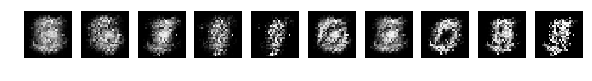

speed: 93.99640607833862 seconds
distance = 2.192017 at epoch 30


<Figure size 432x288 with 0 Axes>

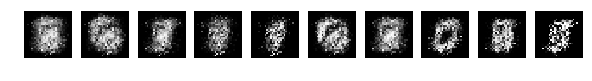

speed: 94.77050352096558 seconds
distance = 9.241531 at epoch 35


<Figure size 432x288 with 0 Axes>

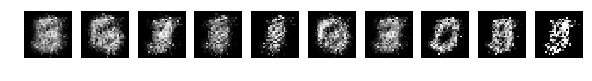

speed: 95.15988373756409 seconds
distance = 56.697105 at epoch 40


<Figure size 432x288 with 0 Axes>

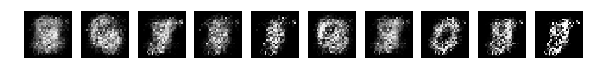

speed: 95.11862087249756 seconds
distance = -21.486938 at epoch 45


<Figure size 432x288 with 0 Axes>

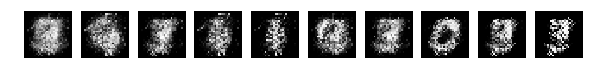

speed: 96.12487578392029 seconds
distance = 30.136932 at epoch 50


<Figure size 432x288 with 0 Axes>

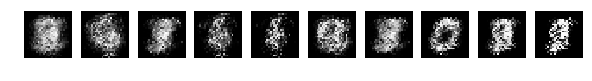

speed: 94.82571625709534 seconds
distance = 31.728615 at epoch 55


<Figure size 432x288 with 0 Axes>

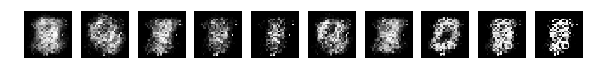

speed: 95.15652680397034 seconds
distance = -7.606369 at epoch 65


<Figure size 432x288 with 0 Axes>

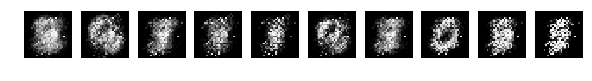

speed: 94.35229325294495 seconds
distance = 42.636765 at epoch 70


<Figure size 432x288 with 0 Axes>

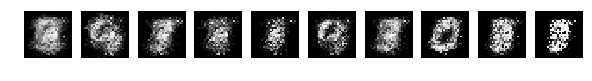

speed: 96.11999583244324 seconds
distance = -15.979080 at epoch 75


<Figure size 432x288 with 0 Axes>

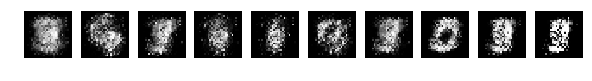

speed: 95.87322950363159 seconds
distance = -4.119125 at epoch 80


<Figure size 432x288 with 0 Axes>

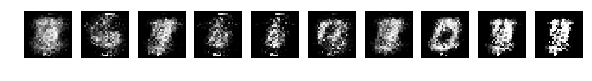

speed: 95.16799092292786 seconds
distance = 33.834503 at epoch 85


<Figure size 432x288 with 0 Axes>

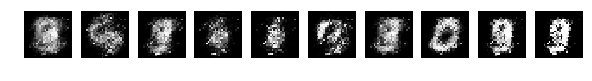

speed: 95.27542304992676 seconds
distance = -20.635384 at epoch 90


<Figure size 432x288 with 0 Axes>

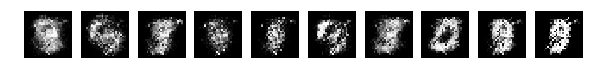

speed: 95.24250793457031 seconds
distance = 8.515327 at epoch 95


<Figure size 432x288 with 0 Axes>

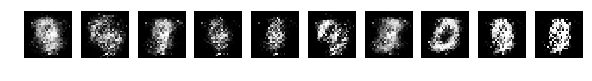

<Figure size 432x288 with 0 Axes>

In [23]:
from tqdm import tqdm, tqdm_notebook
import matplotlib

z_fixed = nd.random.normal(shape = (10, latent_dim), ctx = ctx)
_lambda = nd.array([0.1], ctx = ctx)[0]
for epoch in tqdm_notebook(range(epochs), desc = 'epoch'):
    btic = time.time()
    train_data.reset()
    ############################
    # (1) Update Critique network: maximize E(f_w(X)) - E(f_w(G(z))) (searching for more accurate distance)
    ###########################
    wasserstein_d = 0
    for i, batch in enumerate(train_data):
        real_data = batch.data[0].as_in_context(ctx)
        # zerorize gradient
        for param in critic.params:
            param.zero_grad()
            
        for j in range(n_critic_steps):
            latent_z = nd.random.normal(shape =(batch_size, latent_dim), ctx = ctx) # Latent data
            with autograd.record():
                fake_data = gen(latent_z)
                c_real = nd.mean(critic(real_data))
                c_fake = nd.mean(critic(fake_data))
                crit_cost = - (c_real - c_fake) + get_penalty(critic, real_data, fake_data, _lambda)
                crit_cost.backward()
            critic_trainer.step(batch_size)
            wasserstein_d = c_real - c_fake
        
        ############################
        # (2) Update G network: maximize g_theta(z)
        ###########################
        # zerorize gradient
        for param in gen.params:
            param.zero_grad()
            
        latent_z = nd.random.normal(shape = (batch_size, latent_dim), ctx =ctx)
        with autograd.record():
            fake = gen(latent_z)
            g = nd.mean(critic(fake))
            g_cost = - g
            g_cost.backward()
        gen_trainer.step(batch_size)
        
    #save dis/gen loss
    if epoch % log_freq == 0:
        tqdm.write('speed: {} seconds'.format(time.time() - btic))
        tqdm.write('distance = %f at epoch %d'%(wasserstein_d.asscalar(), epoch))
        iter_loss['crit'].append(crit_cost.asnumpy()[0])
        iter_loss['gen'].append(g_cost.asnumpy()[0])
        
        #print('z shape = {}'.format(z.shape))
        gen_img = gen(z_fixed)
        _norm_img = np.reshape(gen_img.asnumpy(), (-1, 28, 28))
        plt.figure(figsize=(10,10))
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(_norm_img[i], cmap='Greys_r')
            plt.axis('off')
        plt.show()
        plt.savefig('../output/test_{}.png'.format(epoch))

In [ ]:
z_fixed = nd.random.normal(shape = (10, latent_dim), ctx = ctx)
gen_img = gen(z_fixed)

In [ ]:
_norm_img = np.reshape(gen_img.asnumpy(), (-1, 28, 28))*2 +.5


In [ ]:
_norm_img.shape

In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(_norm_img[i])
    plt.axis('off')
plt.show()

In [ ]:
z = nd.random.uniform(shape = (1, 100), ctx = mx.gpu(0))
gen_img = gen(z)
visualize(nd.array(np.squeeze(gen_img.asnumpy(), axis = 0), ctx  = mx.gpu(0)))